In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imageio
import tiffile
import scipy.ndimage as ndi

# Numpy and Matplotlib

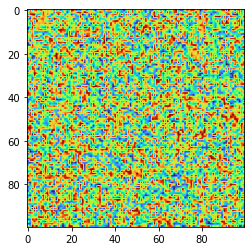

In [2]:
# An image is just an array of values.  Each pixel could be a measurement (temp, elevation) or 
# spectral info (RGB) or multiband data.

# I like to use capital letters to indicate 2D or nD arrays, but it's not necessary.

X = np.random.rand(100,100)
plt.imshow(X,cmap='turbo')

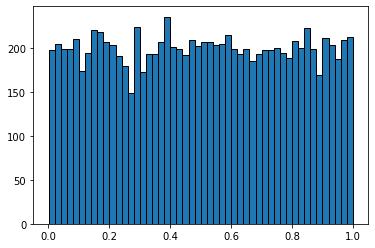

In [5]:
_ = plt.hist(X.flatten(),bins=50,edgecolor='black')

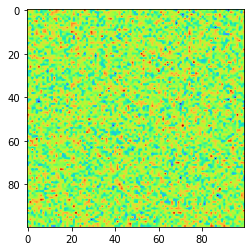

In [6]:
X = np.random.randn(100,100)
plt.imshow(X,cmap='turbo')

# Matplotlib can also save renders of array data (images) to disk by applying a colormap
# This isn't the same as saving the raw data!
plt.imsave('random.png',X,cmap='turbo')

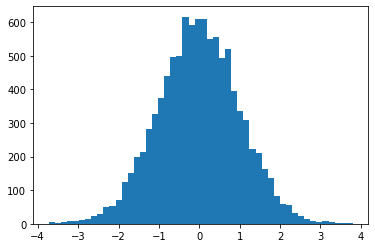

In [7]:
_ = plt.hist(X.flatten(),bins=50)

(2190, 2280, 3)


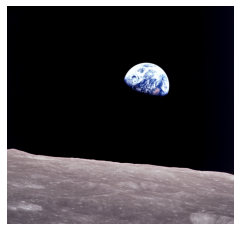

In [12]:
# Matplotlib can be used to load images as well.  This is the Apollo Earthrise photo from:
# https://www.nasa.gov/sites/default/files/thumbnails/image/apollo08_earthrise.jpg

X = plt.imread('data/apollo08_earthrise.jpg')
print(np.shape(X))
plt.imshow(X)
_ = plt.axis('off')

## Interpolating an image from points

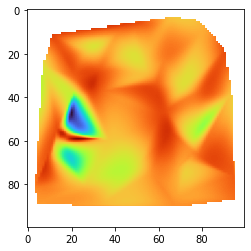

In [14]:
from scipy import interpolate

x,y,z = np.random.rand(3,50)      # 50 random points between 0 and 1, z is a measurement
xi = yi = np.linspace(0,1,100)    # defining the edges of a raster/image between 0 and 1
XI,YI = np.meshgrid(xi,yi)        # Meshgrid defines XI and YI for all edges
Z = interpolate.griddata((x,y),z,(XI,YI),'cubic',fill_value=np.nan)
plt.imshow(Z,cmap='turbo')

# ImageIO

In practice, matplotlib isn't often used to load data; it's more appropriate for simple RGB images.  There are several simple image loaders, but my favorite is ImageIO.  ImageIO won't handle the spatial part of geospatial data (i.e., coordinate reference system, etc.) but it will read the data just fine.

In [17]:
#!pip install cmocean   # Install with pip install cmocean, if needed

import imageio
import cmocean       

# Elevation Data

(1438, 2007)


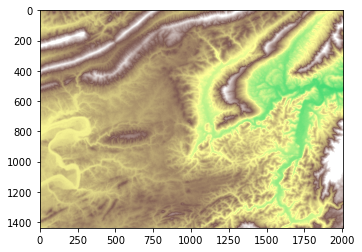

In [18]:
# DEM Data

I = imageio.v2.imread('https://github.com/thomaspingel/geodata/raw/master/nasadem_blacksburg_area.tif')
print(np.shape(I))
plt.imshow(I,cmap='terrain',vmin=100,vmax=np.percentile(I,99))

# Thermal Data

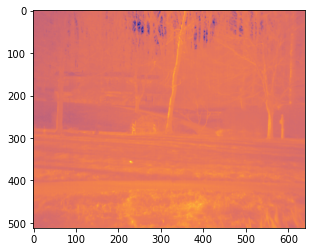

In [19]:
# This is some thermal data

I = imageio.v2.imread('https://github.com/thomaspingel/geodata/raw/master/images/thermal.tif')
plt.imshow(I,cmap=cmocean.cm.thermal)

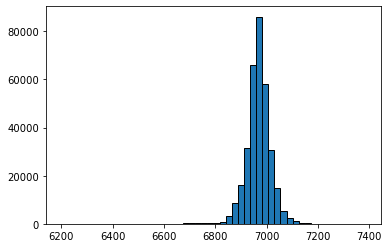

In [21]:
# Remember that these are just numpy arrays!

_ = plt.hist(I.flatten(),bins=50,edgecolor='black')

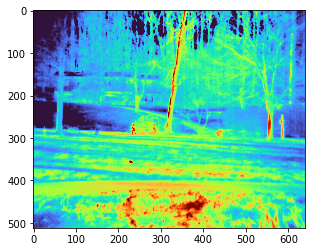

In [22]:
# The values recorded in this array have to be rescaled.  This is not uncommon with data.  Much satellite data gets
# transmitted this way.  Why?  Because integer values are smaller and more precise to record.

T = 0.04 * I - 273.15   # This equation governs the conversion from recorded values to temperatures.
                        # Source: https://www.researchgate.net/post/FLIR-Vue-Pro-How-do-we-extract-temperature-from- ...
                        # TIFF-16-bit-data-raw-data

# You'll notice the range isn't very tight, min/max isn't a good way to visualize.  
# You can trim with percentages like this:

plt.imshow(T,cmap='turbo',vmin=np.percentile(T,5),vmax=12)

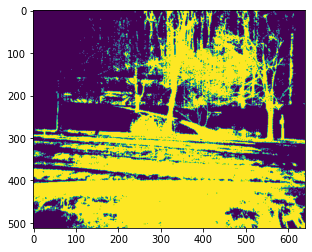

In [23]:
# Simple queries can be used to create binary masks above/below a threshold:

plt.imshow(T > np.median(T))

## Radar Data

Much image data is distributed as either TIFs (multi-use, single-band like elevation or multi-band like satellite data),
JPG or JP2 (orthomosaics), but some is distributed as PNGs.  PNGs record integer values, but as we saw before, they can be rescaled to recover the true quantitative data.  They also often feature colormaps that are applied to the image.  Unlike
JPGs that have three bands (red, green, blue, or RGB), these are indexed images, which means they include a "key" or "legend" that tells the system how to represent them.  But they ALSO include the data.  

What's the advantange?  By not recording the colors at each pixel value, it can greatly reduce the size of the image.  For example, in the radar images below, both TIFs and PNGs are provided.  Uncompressed TIFs are 15 MB, while PNGs are 265 KB.  However: compression can be applied to TIFs, and this reduces their size to only 1-2 KB that of PNGs, AND they can save colormaps, AND they can save geospatial information.  PNGs can  be georeferenced with the world file ([look for WLD files](https://mesonet.agron.iastate.edu/archive/data/2005/08/29/GIS/uscomp)), but they still won't contain the CRS/Projection information.  For this reason, TIFs are generally preferred.

Take a moment to look at [Iowa State's radar composite NEXRAD mosaic](https://mesonet.agron.iastate.edu/docs/nexrad_mosaic/).

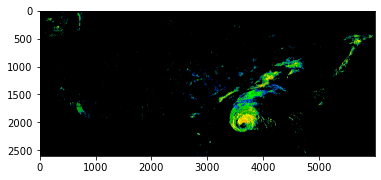

In [25]:
# Let's look at an interesting radar image, the landfall of Hurricane Katrina.  Compare the image to what you see
# when you load the image in a browser.  They should be the same!

url = 'https://mesonet.agron.iastate.edu/archive/data/2005/08/29/GIS/uscomp/n0r_200508291300.png'
I = imageio.v2.imread(url)
plt.imshow(I)

In [26]:
# What are we seeing?  We're seeing a render of the image data.  It isn't the radar data, it's a vision of it.
# Notice the shape has four bands, the Red, Green, Blue, and Alpha bands.  An alpha is transparency, and is common
# with PNG data.

np.shape(I)

(2600, 6000, 4)

In [27]:
# Look again at the documentation.  This image is indexed, and the data here (since they're older) are 4-bit values.
# 0 is NoData, and 22 is the highest value.  These are mapped to colors, and those colors are stored with the image 
# data.  How can we access the actual data?
#
# The v3 method provides this easily, returning the index array, and the palette through a separate call.

I = imageio.v3.imread(url)
meta = imageio.v3.immeta(url)

print(np.shape(I))
meta

(2600, 6000)


{'dpi': (71.9836, 71.9836),
 'mode': 'P',
 'shape': (6000, 2600),
 'palette': <PIL.ImagePalette.ImagePalette at 0x2106298df10>}

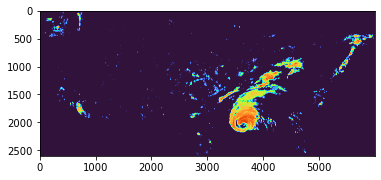

In [28]:
# Now we can apply our own colormap, if we wish:

plt.imshow(I,cmap='turbo')

In [29]:
# Play along! What the minimum non-nodata value in the dataset?  What's the max?
# What dBZ values do these correspond to?

np.max(I)

17

In [30]:
# Play along!  Can you convert the image array to dBZ based on the documentation?  
# Replace the X with the appropriate value.

dbz = X * I.astype(float) - X
dbz[dbz < X] = np.nan

## Batch Processing

Often times you'll want to process a large number of images (or other geospatial data!).  To do this, use glob.

In [32]:
import glob
import os

In [33]:
fns = glob.glob('data/sixty_thermal_images/*.tif')
for fn in fns:
    print(fn)

In [34]:
low = 9999
high = -9999

out_dir = 'out'

fns = glob.glob(r'c:\data\Classes\Current\Algorithms\content\05 - Open Source Python GIS\data\sixty_thermal_images\*.tif')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for fn in fns:
    # Pull the basename without the whole path
    print(os.path.basename(fn))
    
    # Load the data and convert
    I = imageio.v3.imread(fn)
    
    # Calculate the low and high
    low = np.min([low,np.min(I)])
    high = np.max([high,np.max(I)])
    
for fn in fns:
    I = imageio.v3.imread(fn)
    plt.imsave(out_dir + '/' + os.path.basename(fn)[:-6] + '.png',I,vmin=low,vmax=high,cmap='turbo')
    
# Play along!  Adjust the vmin and vmax numbers to get an image you like

# PIL and Pillow

[PIL](https://realpython.com/image-processing-with-the-python-pillow-library/) is the Python Image Library, and [Pillow](https://pillow.readthedocs.io/en/stable/) is a fork of it.  I don't use either of these two regularly, but you never know what will come in handy.  I consider it a fairly low-level tool for interaction with few dependencies.

In [36]:
from PIL import Image

In [38]:
fn = 'data/thermal.tif'
with Image.open(fn) as img:
    img.load()
type(img)

PIL.TiffImagePlugin.TiffImageFile

In [39]:
# You can calculate the entropy in the image

img.entropy()

4.992607083441339

In [40]:
# Or get EXIF information

print(img.getexif())

{34665: 657458, 34853: 657624, 256: 640, 257: 512, 258: 16, 259: 1, 262: 1, 271: 'FLIR', 272: 'Duo Pro R', 273: 8, 339: 1, 277: 1, 278: 512, 279: 655360, 282: 72.0, 283: 72.0, 284: 1, 296: 2, 297: (0, 1), 50735: '302569', 305: 'V01.03.03', 700: b'<?xpacket begin="" id="W5M0MpCehiHzreSzNTczkc9d"?>\r\n<rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"\r\nxmlns:Camera="http://pix4d.com/camera/1.0/"\r\nxmlns:FLIR="http://ns.flir.com/xmp/1.0/">\r\n<rdf:Description rdf:about="">\r\n<Camera:BandName>\r\n<rdf:Seq>\r\n<rdf:li>LWIR</rdf:li>\r\n</rdf:Seq>\r\n</Camera:BandName>\r\n<Camera:CentralWavelength>\r\n<rdf:Seq>\r\n<rdf:li>10000</rdf:li>\r\n</rdf:Seq>\r\n</Camera:CentralWavelength>\r\n<Camera:WavelengthFWHM>\r\n<rdf:Seq>\r\n<rdf:li>4500</rdf:li>\r\n</rdf:Seq>\r\n</Camera:WavelengthFWHM>\r\n<Camera:TlinearGain>0.04</Camera:TlinearGain>\r\n<Camera:Yaw>7707/100</Camera:Yaw>\r\n<Camera:Pitch>370/100</Camera:Pitch>\r\n<Camera:Roll>50/100</Camera:Roll>\r\n<Camera:GPSXYAccuracy>6.00

In [41]:
# Or variety of other things!

dir(img)

['_Image__transformer',
 '_TiffImageFile__first',
 '_TiffImageFile__frame',
 '_TiffImageFile__next',
 '__array_interface__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_category',
 '_close_exclusive_fp_after_loading',
 '_compression',
 '_copy',
 '_crop',
 '_dump',
 '_ensure_mutable',
 '_exclusive_fp',
 '_exif',
 '_expand',
 '_fp',
 '_frame_pos',
 '_get_safe_box',
 '_getxmp',
 '_load_libtiff',
 '_min_frame',
 '_n_frames',
 '_new',
 '_open',
 '_planar_configuration',
 '_reload_exif',
 '_repr_png_',
 '_repr_pretty_',
 '_seek',
 '_seek_check',
 '_setup',
 '_size',
 '_tile_orient

# Tifffile

Tifffile allows the reading and writing of [BigTiff Format](https://www.loc.gov/preservation/digital/formats/fdd/fdd000328.shtml) for very large image data (up to 18,000 petabytes!).  A normal TIF can be up to about 2 to 4 GB only.  This is often not strictly necessary, as imageio will generally read these formats as well.

We record a full-resolution small-multiples image, where each image is approximately HD size (1920 x 1080) and there are around 24 x 30 images, one more each hour of each day of the month.  The result for February is an image 31920 x 21600 pixels in size.  Imageio can't read it, but tifffile can.

Try this only if your computer has a lot of memory!

In [46]:
import tifffile

In [ ]:
X = np.random.rand(30000,30000)
tifffile.imwrite('bigtiff.tif',X)

# ndimage

ndimage is SciPys multidimensional image processing engine.  It can load and write files, but it is primarily used for processing the data.

In [48]:
import scipy.ndimage as ndi

## Focal statistics / neighborhood calculations

In GIS, focal statistics are calculated a 2D moving calculations on a raster.  For instance, you might smooth a DEM by taking the mean of a each pixel's surrounding 8 (or more) pixels.  The neighorhood is defined by a shape, typically called a structuring element, and can be either binary (in-or-out) or gray (distance decay, inverse distance weighting).  NDI provides easy inferfaces for calculations like these.

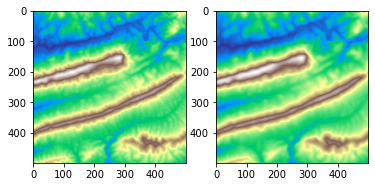

In [49]:
X = imageio.v2.imread('https://github.com/thomaspingel/geodata/raw/master/nasadem_blacksburg_area.tif')

# Apply a median filter, where the second value is a size of the window, generally odd.
# This applies a rectangular neighorhood (e.g., 11x11).  Alternatively, one can also apply
# a more carefully crafted footprint which can be circular, or a torus, or anything desired.
# Think of a footprint like a "paintbrush"
Xm = ndi.median_filter(X,11)

plt.subplot(121)
plt.imshow(X[0:500,0:500],cmap='terrain')
plt.subplot(122)
plt.imshow(Xm[0:500,0:500],cmap='terrain')

NDI provides a number of different filters for use, too many to list here (but not [here](https://docs.scipy.org/doc/scipy/reference/ndimage.html#filters)), but here are a few favorites:
* [convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html) - a filter that sums all pixel values within a radius.  Divide by size**2 to get an average.  For special cases, [fftconvolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html) is 25x faster.
* [gaussian_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) - A "gray" filter where the weight of the filter diminishes with distance
* [maximum_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html), [minimum_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.minimum_filter.html), [percentile_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.percentile_filter.html), [rank_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rank_filter.html)
* Edge filters like [sobel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html) and [prewitt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.prewitt.html) filters.
* [generic_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html) - Pass any function to act as the filter.  But it's slow!

In [51]:
# Many filters require not a size but an explicit footprint.  You can use a simple numpy array.

X = np.ones((5,5))

footprint = np.ones((3,3))
ndi.convolve(X,footprint)

# Play along.  How would you calculate the average?  Can you calculate a moving
# average of the DEM above?

array([[9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9.]])

### Footprints / Structuring Elements

More complicated footprints are also possible.  Use these to generate more complex ones.  For binary (in-or-out) neighborhoods, boolean values are common.

In [52]:
# "Rook" and "Queen" Connectivity
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html

# The first value is number of dimensions, the second is the "rank" connectivity (1,2)
strel = ndi.generate_binary_structure(2,2)
print(strel)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [53]:
# We'll scikit-image in a bit, but scikit-image has many more structuring elements:
# https://scikit-image.org/docs/stable/auto_examples/numpy_operations/plot_structuring_elements.html

from skimage.morphology import disk

disk(5)

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

In [54]:
# You can also design your own.  This calculated distance from a center pixel

def distance_kernel(radius,normalize=False):
    window = (radius*2 + 1)
    xi,yi = np.meshgrid(np.arange(window)-np.floor(window/2),np.arange(window)-np.floor(window/2))
    D = (xi**2 + yi**2)**.5
    return D

D = distance_kernel(4)

np.set_printoptions(precision=2)
D

array([[5.66, 5.  , 4.47, 4.12, 4.  , 4.12, 4.47, 5.  , 5.66],
       [5.  , 4.24, 3.61, 3.16, 3.  , 3.16, 3.61, 4.24, 5.  ],
       [4.47, 3.61, 2.83, 2.24, 2.  , 2.24, 2.83, 3.61, 4.47],
       [4.12, 3.16, 2.24, 1.41, 1.  , 1.41, 2.24, 3.16, 4.12],
       [4.  , 3.  , 2.  , 1.  , 0.  , 1.  , 2.  , 3.  , 4.  ],
       [4.12, 3.16, 2.24, 1.41, 1.  , 1.41, 2.24, 3.16, 4.12],
       [4.47, 3.61, 2.83, 2.24, 2.  , 2.24, 2.83, 3.61, 4.47],
       [5.  , 4.24, 3.61, 3.16, 3.  , 3.16, 3.61, 4.24, 5.  ],
       [5.66, 5.  , 4.47, 4.12, 4.  , 4.12, 4.47, 5.  , 5.66]])

In [55]:
# Which you can then manipulate:

D = distance_kernel(4)
D = (D.max() - D) / D.max()
D

array([[0.  , 0.12, 0.21, 0.27, 0.29, 0.27, 0.21, 0.12, 0.  ],
       [0.12, 0.25, 0.36, 0.44, 0.47, 0.44, 0.36, 0.25, 0.12],
       [0.21, 0.36, 0.5 , 0.6 , 0.65, 0.6 , 0.5 , 0.36, 0.21],
       [0.27, 0.44, 0.6 , 0.75, 0.82, 0.75, 0.6 , 0.44, 0.27],
       [0.29, 0.47, 0.65, 0.82, 1.  , 0.82, 0.65, 0.47, 0.29],
       [0.27, 0.44, 0.6 , 0.75, 0.82, 0.75, 0.6 , 0.44, 0.27],
       [0.21, 0.36, 0.5 , 0.6 , 0.65, 0.6 , 0.5 , 0.36, 0.21],
       [0.12, 0.25, 0.36, 0.44, 0.47, 0.44, 0.36, 0.25, 0.12],
       [0.  , 0.12, 0.21, 0.27, 0.29, 0.27, 0.21, 0.12, 0.  ]])

In [58]:
# Or exclude anything outside a radius (i.e, make it circular).  

radius = 3

D = distance_kernel(radius)
idx = D > radius
D = (D.max() - D) / D.max()
D[idx] = 0
D

array([[0.  , 0.  , 0.  , 0.29, 0.  , 0.  , 0.  ],
       [0.  , 0.33, 0.47, 0.53, 0.47, 0.33, 0.  ],
       [0.  , 0.47, 0.67, 0.76, 0.67, 0.47, 0.  ],
       [0.29, 0.53, 0.76, 1.  , 0.76, 0.53, 0.29],
       [0.  , 0.47, 0.67, 0.76, 0.67, 0.47, 0.  ],
       [0.  , 0.33, 0.47, 0.53, 0.47, 0.33, 0.  ],
       [0.  , 0.  , 0.  , 0.29, 0.  , 0.  , 0.  ]])

In [59]:
# You could use inverse distance weighting on any of these to change the rate at which

D = D**2
D

array([[0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  ],
       [0.  , 0.11, 0.22, 0.28, 0.22, 0.11, 0.  ],
       [0.  , 0.22, 0.44, 0.58, 0.44, 0.22, 0.  ],
       [0.09, 0.28, 0.58, 1.  , 0.58, 0.28, 0.09],
       [0.  , 0.22, 0.44, 0.58, 0.44, 0.22, 0.  ],
       [0.  , 0.11, 0.22, 0.28, 0.22, 0.11, 0.  ],
       [0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  ]])

In [60]:
# Play along!  Can you use these structure elements to process the DEM?

### What happens at the edges?

Most of these filters have a "mode" where you can indicate what you want to happen beyond the limits of your array.

The mode parameter determines how the input array is extended when the filter overlaps a border. By passing a sequence of modes with length equal to the number of dimensions of the input array, different modes can be specified along each axis. Default value is ‘reflect’. The valid values and their behavior is as follows:

‘reflect’ (d c b a | a b c d | d c b a)
The input is extended by reflecting about the edge of the last pixel. This mode is also sometimes referred to as half-sample symmetric.

‘constant’ (k k k k | a b c d | k k k k)
The input is extended by filling all values beyond the edge with the same constant value, defined by the cval parameter.

‘nearest’ (a a a a | a b c d | d d d d)
The input is extended by replicating the last pixel.

‘mirror’ (d c b | a b c d | c b a)
The input is extended by reflecting about the center of the last pixel. This mode is also sometimes referred to as whole-sample symmetric.

‘wrap’ (a b c d | a b c d | a b c d)
The input is extended by wrapping around to the opposite edge.

## Interpolation

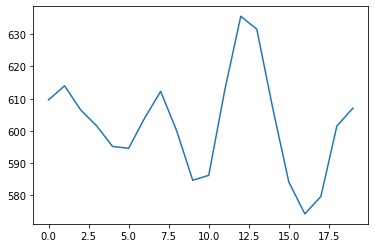

In [62]:
# Given a DEM, interpolate a transect between two known points:

I = imageio.v2.imread('https://github.com/thomaspingel/geodata/raw/master/nasadem_blacksburg_area.tif')

# Pull two random pixels
a,b = [5,7],[88,90]

# Extract transect coordinates
resolution = 20  # How many points to sample
row_points = np.linspace(a[0],b[0],resolution)
col_points = np.linspace(a[1],b[1],resolution)

# The pull the coordinates
values = ndi.map_coordinates(I,[row_points,col_points],order=1)

# Plot the transect
plt.plot(values)

## Morphological operations

The raster equivalent to a "buffer" operation is a "dilation".  The inverse of that is an erosion.  An opening is a erosion followed by a dilation, and a closing is a dilation followed by an erosion. NDI lets you apply these operations to binary images.  scikit-image will let us do the same for gray images (like a DEM), so will be much more useful.

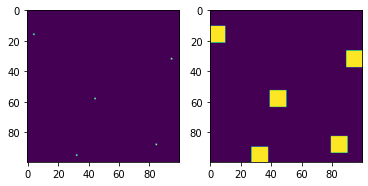

In [63]:
X = np.zeros((100,100),dtype=bool)
rows = np.random.choice(100,5)
cols = np.random.choice(100,5)
X[rows,cols] = True

X_dilated = ndi.binary_dilation(X,structure=np.ones((11,11)))

plt.subplot(121)
plt.imshow(X)
plt.subplot(122)
plt.imshow(X_dilated)

# Scikit Image

Scikit-Image (skimage) is a very similar package to ndimage, but has some additional useful operations for grayscale images, very common for geospatial data.  A DEM, for example, is a "grayscale" image, since it's a single layer.  A list of morphological operations for skimage is [here](https://scikit-image.org/docs/stable/api/skimage.morphology.html).

In [64]:
import skimage

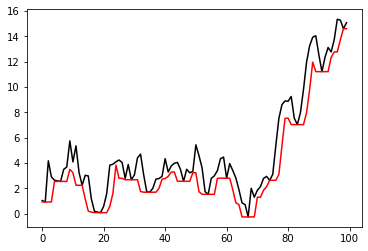

In [65]:
# Let's take a 1D case of a "random walk".  In this case a grayscale erosion will do a 
# neighborhood search to find the lowest value within the range and it will "snap" to that.
# Look for minima on the original (black) to touch the red line.  The highs get lower in an
# erosion

y = np.cumsum(np.random.randn(100))
width = 5

plt.plot(y,'k')
plt.plot(skimage.morphology.erosion(y.reshape((-1,1)),footprint=np.ones((width,1))),'r')

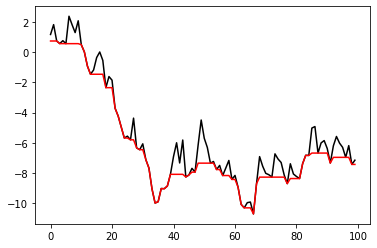

In [66]:
# Play along!  What happens when you try different widths?  What happens for dilations, openings
# and closings?

y = np.cumsum(np.random.randn(100))
width = 5

plt.plot(y,'k')
plt.plot(skimage.morphology.opening(y.reshape((-1,1)),footprint=np.ones((width,1))),'r')

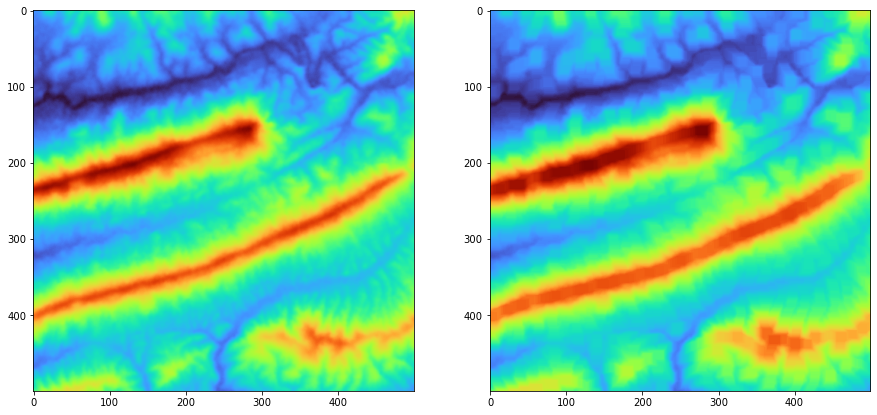

In [67]:
# What do morphological operations look like on a DEM?  It flattens the highs!

X = imageio.v2.imread('https://github.com/thomaspingel/geodata/raw/master/nasadem_blacksburg_area.tif')
Xopen = skimage.morphology.opening(X,np.ones((11,11)))

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(X[:500,:500],cmap='turbo')
plt.subplot(122)
plt.imshow(Xopen[:500,:500],cmap='turbo')

Why would I use this?  Morphological operations are very useful in things like lidar filtering.  My lidar ground filtering algorithm SMRF (Simple Morphological Filter) is powered partly by morphological opening.  https://github.com/thomaspingel/smrf

## Scikit-Image is Huge

Read through [the gallery](https://scikit-image.org/docs/stable/auto_examples/index.html) carefully!  nearly anything you might want to do with raster data can be done with scikit-image.

# OpenCV

[OpenCV](https://opencv.org/) is a Computer Vision package, mostly written in C but with Python bindings.  It can do many things other packages can do, including image loading, image conversion, etc., but it can also interface with imaging devices (like webcams or other sensors) and has capability for handling point clouds.

Install with pip:
~~~
pip install opencv-python
~~~

In [70]:
#!pip install opencv-python    # Install from the notebook as needed

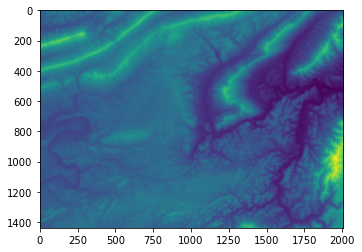

In [71]:
# A simple median blur:

import cv2

X = imageio.v2.imread('https://github.com/thomaspingel/geodata/raw/master/nasadem_blacksburg_area.tif')
I = cv2.medianBlur(X,5)

plt.imshow(I)

## Access a webcam

In [74]:
#!pip install ipywidgets            # Install as needed

In [75]:
import cv2
from IPython.display import display, Image
import ipywidgets as widgets
import threading

In [76]:
cap = cv2.VideoCapture(0)
cap.set(3,640) # adjust width
cap.set(4,480) # adjust height

# QUIT when Q is pressed

while True:
    success, img = cap.read()
    cv2.imshow("Webcam", img) # This will open an independent window
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
        cap.release()
        break
        
cv2.destroyAllWindows() 
cv2.waitKey(1) # normally unnecessary, but it fixes a bug on MacOS where the window doesn't close

KeyboardInterrupt: 

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

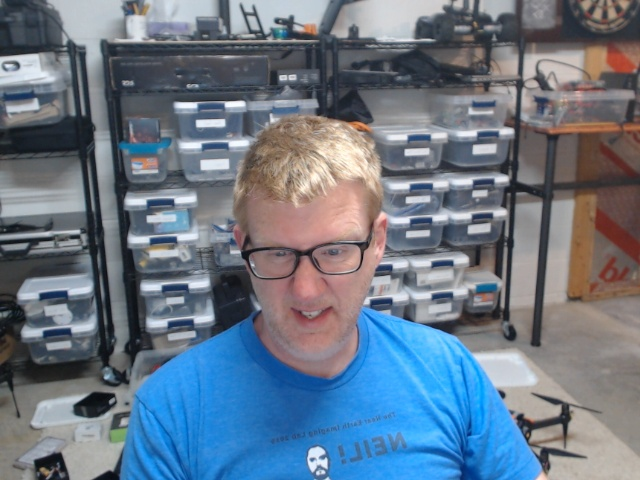

In [77]:
# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

# Special Topics

## Blocksum / Aggregate

Sometimes images need to be upsampled or downsampled.  These tools can do that, too!

In [78]:
# As a simple example, take a 25x25 array of ones.

X = np.ones((25,25))

In [79]:
# If we want to make this a 5x5 array, we can either interpolate, or take the block sum:

from skimage.util import view_as_blocks
import rioxarray


ModuleNotFoundError: No module named 'rioxarray'

In [80]:
!pip install rioxarray

     ---------------------------------------- 53.5/53.5 kB 1.4 MB/s eta 0:00:00
     ------------------------------------- 994.3/994.3 kB 10.6 MB/s eta 0:00:00
